In [1]:
from osgeo import gdal, gdal_array
import numpy as np
import os
from terracatalogueclient import Catalogue 
from shapely.geometry import Polygon
import geopandas as gpd
from shapely.geometry import box

In [2]:
# create catalogue object and authenticate 
catalogue = Catalogue().authenticate() 

# search for products in the WorldCover collection 
products = catalogue.get_products("urn:eop:VITO:ESA_WorldCover_10m_2020_V1") 

# download the products to the given directory 
catalogue.download_products(products, "downloads") 

### Authenticate to the Terrascope platform (registration required) 
# create catalogue object and authenticate interactively with a browser 
# catalogue = Catalogue().authenticate()  

# or authenticate with username and password 
catalogue = catalogue.authenticate_non_interactive("username", "Password") 

### Filter catalogue 
# search for all products in the WorldCover collection 
products = catalogue.get_products("urn:eop:VITO:ESA_WorldCover_10m_2020_V1") 
products
# or filter to a desired geometry, by providing it as an argument to get_products 

bounds = (3, 33, 15, 45) 
geometry = Polygon.from_bounds(*bounds) 
#products = catalogue.get_products("urn:eop:VITO:ESA_WorldCover_10m_2020_V1", geometry=geometry) 

### Download 
# download the products to the given directory 
#catalogue.download_products(products, "downloads") 

You are about to download 160.99 GB, do you want to continue? [Y/n]  n


In [2]:
# get AOI geometry (select a country name)
country = 'Somalia'

In [6]:

s3_url_prefix = "https://esa-worldcover.s3.eu-central-1.amazonaws.com"

# load natural earth low res shapefile
ne = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

geom = ne[ne.name == country].iloc[0].geometry

# Define the bounding box coordinates: [minx, miny, maxx, maxy]
bbox = [40.39407136, -1.92483662, 51.58562142, 13.63884234]

# Create a GeoDataFrame with a single geometry representing the bounding box
geom1 = gpd.GeoDataFrame(geometry=[box(bbox[0], bbox[1], bbox[2], bbox[3])], crs='EPSG:4326')
geom1= geom1.geometry.iloc[0]
#print(geom)
#geom = gpd.[40.39407136, -1.92483662, 51.58562142, 13.63884234].geometry

# load worldcover grid
url = f'{s3_url_prefix}/esa_worldcover_grid.geojson'
#print(url)
grid = gpd.read_file(url)
#grid = grid.reset_index(drop=True)
# get grid tiles intersecting AOI

# Reset indices of both GeoDataFrames
#grid = grid.reset_index(drop=True)
#geom = geom.reset_index(drop=True)
tiles = grid[grid.intersects(geom1)]
#tiles = gpd.overlay(grid, geom1, how='intersection')


AttributeError: 'Polygon' object has no attribute 'plot'

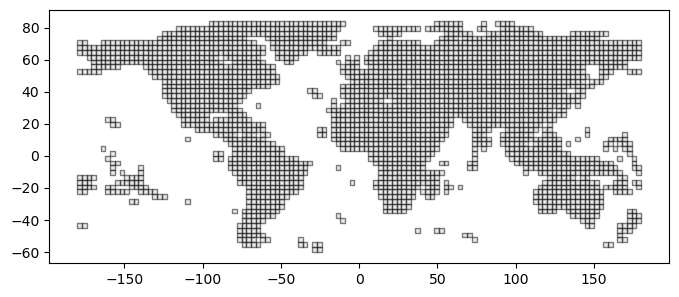

In [64]:

import matplotlib.pyplot as plt
# Plot both GeoDataFrames on the same figure
fig, ax = plt.subplots(figsize=(8, 8))

# Plot the grid GeoDataFrame
grid.plot(ax=ax, color='lightgray', edgecolor='black', alpha=0.5)

# Plot the bounding box GeoDataFrame
geom1.plot(ax=ax, color='red', alpha=0.5)

# Customize the plot as needed
ax.set_title("Overlay of GeoDataFrames")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# Show the plot
plt.show()

In [4]:
# define the output folder path
output_folder = r"C:\Users\oscar.bautista\OneDrive - World Food Programme\Downloads\WC_ESA"+f"/{country}"  # use current directory or set a different one to store downloaded files
# create the directory if it does not exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

In [5]:
# use requests library to download them
import requests
from tqdm.auto import tqdm  # provides a progressbar
from pathlib import Path

year = 2021  # setting this to 2020 will download the v100 product instead

# select version tag, based on the year
version = {2020: 'v100',
           2021: 'v200'}[year]

for tile in tqdm(tiles.ll_tile):
    url = f"{s3_url_prefix}/{version}/{year}/map/ESA_WorldCover_10m_{year}_{version}_{tile}_Map.tif"
    out_fn = Path(output_folder) / Path(url).name
    if not out_fn.exists():
        r = requests.get(url, allow_redirects=True)
        with open(out_fn, 'wb') as f:
            f.write(r.content)

NameError: name 'tiles' is not defined

In [7]:
from osgeo import gdal, gdal_array
import numpy as np
import os

# Set the working directory where your TIFF files are located
#working_directory = r"C:\Users\oscar.bautista\OneDrive - World Food Programme\Downloads\WC_ESA"

# List all TIFF files in the working directory with complete file paths
tif_files = [os.path.join(output_folder, f) for f in os.listdir(output_folder) if f.endswith('.tif')]

for i in tif_files:
    print(i)


C:\Users\oscar.bautista\OneDrive - World Food Programme\Downloads\WC_ESA/Somalia\ESA_WorldCover_10m_2021_v200_N00E039_Map.tif
C:\Users\oscar.bautista\OneDrive - World Food Programme\Downloads\WC_ESA/Somalia\ESA_WorldCover_10m_2021_v200_N00E042_Map.tif
C:\Users\oscar.bautista\OneDrive - World Food Programme\Downloads\WC_ESA/Somalia\ESA_WorldCover_10m_2021_v200_N00E045_Map.tif
C:\Users\oscar.bautista\OneDrive - World Food Programme\Downloads\WC_ESA/Somalia\ESA_WorldCover_10m_2021_v200_N03E039_Map.tif
C:\Users\oscar.bautista\OneDrive - World Food Programme\Downloads\WC_ESA/Somalia\ESA_WorldCover_10m_2021_v200_N03E042_Map.tif
C:\Users\oscar.bautista\OneDrive - World Food Programme\Downloads\WC_ESA/Somalia\ESA_WorldCover_10m_2021_v200_N03E045_Map.tif
C:\Users\oscar.bautista\OneDrive - World Food Programme\Downloads\WC_ESA/Somalia\ESA_WorldCover_10m_2021_v200_N03E048_Map.tif
C:\Users\oscar.bautista\OneDrive - World Food Programme\Downloads\WC_ESA/Somalia\ESA_WorldCover_10m_2021_v200_N06E039_

In [99]:
# Mosaic TIFF files into one single file
output_mosaic_path = r"C:\Users\oscar.bautista\OneDrive - World Food Programme\Downloads\WC_ESA\mosaic"+f"/{country}"

mosaic_file = output_mosaic_path+"/mosaic_new.vrt"
mosaic_file_tif = output_mosaic_path+"/mosaic.tif"
# create the directory if it does not exist
if not os.path.exists(output_mosaic_path):
    os.makedirs(output_mosaic_path)

#vrt_options = gdal.BuildVRTOptions(resampleAlg='nearest')
vrt_options = gdal.BuildVRTOptions(resampleAlg="nearest", addAlpha=True)
#my_vrt = gdal.BuildVRT(mosaic_file,tif_files, options=vrt_options)
#my_vrt = None
my_vrt = gdal.Open(mosaic_file)



In [97]:

#translate_options = gdal.TranslateOptions(format="GTiff", bandList=[1], creationOptions="COMPRESS=LZW")

mosaic_file_tif = output_mosaic_path+"/mosaic_test.tif"

# Set the target spatial resolution
#target_resolution =  0.0022457882102988
xRes = 0.002245788210298799
yRes = -0.0022457882102988

ops= f"GTiff -ot Byte -b 1 -r mode -tr {xRes} {yRes}"
# Use gdal.Translate to convert VRT to GeoTIFF
gdal.Translate(mosaic_file_tif,mosaic_file, options= ops)#

# Explicitly close the datasets
#my_vrt = None
mosaic_file_tif = None

print("Conversion from VRT to GeoTIFF complete.")

Conversion from VRT to GeoTIFF complete.


In [98]:
from pathlib import Path
#download_folder = Path('C:/Users', username, 'Downloads')

output_mosaic_path = Path(r"C:\Users\oscar.bautista\OneDrive - World Food Programme\Downloads\WC_ESA\mosaic", country)

# Define the reference raster
ref_tiff = r"C:\Geotar\SOM\geodata\Processed\Vegetation\season\ndvi_m_s.tif"

mosaic_file_tif = Path(output_mosaic_path, "mosaic_new.tif")
print(mosaic_file_tif)
# Get the geotransform information of the reference TIFF
ref_ds = gdal.Open(ref_tiff)
# from osgeo import osr
# proj = osr.SpatialReference()
# proj.ImportFromEPSG(4326)
# projection_wkt = proj.ExportToWkt()
# ref_ds.SetProjection(projection_wkt)
ref_geotransform = ref_ds.GetGeoTransform()
ref_geotransform


# Calculate the upper-left (ulx, uly) and lower-right (lrx, lry) coordinates
ulx = ref_geotransform[0]
uly = ref_geotransform[3]
lrx = ulx + ref_ds.RasterXSize * ref_geotransform[1]
lry = uly + ref_ds.RasterYSize * ref_geotransform[5]

# Set options for gdal.Translate
# options = f"-of GTiff -ot Byte -r mode -projWin [{roi[0]}, {roi[1]}, {roi[2]}, {roi[3]}]"
options = f"GTiff -ot Byte -b 1 -r mode -projWin {ulx} {uly} {lrx} {lry}"

kwargs = {
    'format': 'GTiff',
    'outputType': gdal.GDT_Byte,
    #'bandList': [1],
    #'outputBounds': [ulx, uly, lrx, lry],
    'xRes':0.002245788210298799,
    'yRes':-0.0022457882102988,
    'width':4984,
    'height':6932,
    'projWin':[ulx,uly,lrx,lry],
    'projWinSRS': 'EPSG:4326'
}


# Perform the reprojection and windowing
gdal.Translate(str(mosaic_file_tif), mosaic_file, **kwargs)#options=options

mosaic_file_tif = None


C:\Users\oscar.bautista\OneDrive - World Food Programme\Downloads\WC_ESA\mosaic\Somalia\mosaic_new.tif


In [52]:
# Get the CRS information
ref_crs = ref_ds.GetProjection()
mosaic_crs = my_vrt.GetProjection()

# Print the CRS information
print("CRS of ref_tiff:", ref_crs)
print("CRS of mosaic_file:", mosaic_crs)

CRS of ref_tiff: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
CRS of mosaic_file: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]


In [53]:
roi = [ref_geotransform[0], ref_geotransform[3] + ref_ds.RasterYSize * ref_geotransform[5],
       ref_geotransform[0] + ref_ds.RasterXSize * ref_geotransform[1], ref_geotransform[3]]
roi
[40.39274675043421,-1.926886284436371,51.585755190563425,13.64091758935491]


[40.39274675043421, -1.926886284436371, 51.585755190563425, 13.64091758935491]

In [84]:
type(str(mosaic_file_tif))

str